파일 메타데이터 분석

In [1]:
import os
import time
import librosa
import json
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import librosa.display
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap

import datashader as ds
import datashader.transfer_functions as tf

from typing import Union

c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# functions

# json 읽어오는 함수
def read_json(file_path: str) -> str:
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# annotation에 경로 이상한 거 있는 거 수정해주는 함수
def adjust_path(data_prefix: str, file_path: str) -> str:
    return  data_prefix + file_path if file_path.startswith("/") else data_prefix + "/" + file_path

# 각 데이터 개수 구해주는 함수
def count_num_of_data(ann_json: dict, wanted: list, output_with_file_path: bool=False) -> tuple[list, list, set]:
    used_ = set()
    each_count = {k:0 for k in wanted}
    total_count = 0
    
    for ann in ann_json["annotation"]:
        file_path = ann['path'] if ann['path'].startswith('/') else '/' + ann['path'] 

        for keyword in wanted:
            if keyword in file_path:
                if file_path not in used_:
                    used_.add(file_path)
                    total_count += 1
                    each_count[keyword] += 1
                break
    
    if output_with_file_path:
        return total_count, each_count, used_
    else:
        return total_count, each_count, {}

In [65]:
# meta data analysis
def get_metadata_info(ann_json: dict, data_prefix: str, wanted: list, silence_threshold: float=0.0001, is_train=True) -> tuple[pd.DataFrame, list, dict, set]:
    metadata = []
    ann_dict = dict()
    silent_ = set()
    used_ = set()
    
    for ann in ann_json["annotation"]:
        if any(keyword in ann['path'] for keyword in wanted):
            file_path = data_prefix + ann["path"] if ann["path"].startswith("/") else data_prefix + "/" + ann["path"]
            
            if "audiocaps" in file_path:
                file_path = file_path.replace("audiocaps", "audiocaps_1m")
            
            if file_path not in used_:
                try:
                    audio, sr = librosa.load(file_path, sr=16000)
                except:
                    print(f"can't open {file_path}")
                    continue
                duration = librosa.get_duration(y=audio, sr=sr)

                # 무음 비율 계산
                silence_ratio = np.sum(np.abs(audio) < silence_threshold) / len(audio)
                
                snr = calculate_snr(audio)
                
                flatness = calculate_flatness(audio)
                
                rms = cal_mean_rms(audio)
                
                # 무음 비율이 0.99가 최대인데 이정도면 그냥 무음인데? 
                if (file_path, silence_ratio) not in silent_:
                    silent_.add((file_path, silence_ratio))
                
                    with sf.SoundFile(file_path) as sound_file:
                        metadata.append({
                            "filename": ann["path"],
                            "task" : ann["task"],
                            "sample_rate": sr, 
                            "channels" : sound_file.channels,
                            "duration_sec" : duration,
                            "bit_depth" : sound_file.subtype_info,
                            "silence_ratio": silence_ratio,
                            "snr": snr,
                            "flatness": flatness,
                            "rms" : rms
                        })

            if is_train:
                if file_path not in ann_dict.keys():
                    ann_dict[file_path] = {"ann":[(ann["text"], ann["task"])]}
                else:
                    ann_dict[file_path]["ann"].append((ann["text"], ann["task"]))
                
    df_metadata = pd.DataFrame(metadata)
    return df_metadata, metadata, ann_dict, silent_

# 음성 데이터 길이에 따른 개수 분포 출력
def print_audio_duration_distribution(df_metadata: pd.DataFrame, bins: int=50, kde: bool=True):
    plt.figure(figsize=(8, 5))
    sns.histplot(df_metadata["duration_sec"], bins=bins, kde=kde)
    plt.title('Audio Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.show()
    
def calculate_snr(y): # signal to noise ratio
    signal_power = np.mean(y**2)
    noise_power = np.var(y)
    return 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf

def calculate_flatness(y): # flatness
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    avg_flatness = np.mean(spectral_flatness)

    return avg_flatness

def cal_mean_rms(y): # rms (energy)
    # RMS 에너지 계산
    rms = librosa.feature.rms(y=y)[0]
    
    # 평균 에너지
    return np.mean(rms)

In [4]:
# 파형과 스펙트로그램 확인

def print_wav_and_spectogram(file_path: str) -> None:
    audio, sr = librosa.load(file_path, sr=None)

    # 파형 시각화
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

    # 스펙트로그램 시각화
    plt.figure(figsize=(12, 4))
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

In [ ]:
# T-SNE with {mfcc / mel / chroma}
# 1. 오디오 데이터셋 로드 함수
def load_audio_features(ann_json: dict, data_prefix: str, feature_type: str="mfcc", sr: int=16000, n_mfcc: int=13, wanted: list=[]):
    used_ = set()
    features = []
    labels = []

    for ann in ann_json["annotation"]:
        if any(keyword in ann['path'] for keyword in wanted):
            file_path = data_prefix + ann["path"] if ann["path"].startswith("/") else data_prefix + "/" + ann["path"]

            if file_path not in used_:
                used_.add(file_path)
            else:
                continue

            audio, _ = librosa.load(file_path, sr=sr)

            # 2. 특징 추출 (MFCC 또는 Mel-spectrogram)
            if feature_type == "mfcc":
                feature = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
                feature = np.mean(feature.T, axis=0)  # 평균값으로 고정된 크기의 벡터 생성
            elif feature_type == "mel":
                feature = librosa.feature.melspectrogram(y=audio, sr=sr)
                feature = np.mean(feature.T, axis=0)
            elif feature_type == "chroma":
                feature = librosa.feature.chroma_stft(y=audio, sr=sr)
                feature = np.mean(feature.T, axis=0)

            features.append(feature)
            
            if "Clotho" not in ann['path']:
                labels.append(".")
            else:
                labels.append("")
                
            # labels.append(file_path)  # 파일명을 레이블로 저장

    return np.array(features), labels

# 3. t-SNE 적용 및 시각화 함수
def apply_tsne(features: list, labels: list, perplexity: int=30, max_iter: int=5000) -> None:
    # 표준화 (t-SNE는 거리 기반이므로 중요)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # n_components  : 차원 축소 후 출력 차원의 수 (보통 2D or 3D를 사용한다고 함)
    # perplexity    : T-SNE에서 개별 데이터 포인트의 근접 이웃 수를 결정하는 하이퍼파라미터 / 데이터의 밀도를 나타내며, 적절한 값이 모델 성능에 중요한 영향을 미침 / 클러스터링의 밸런스 조정하는 역할
    #                 작은 값 (5 ~ 10) : 지역적인 구조 파아겡 적합, 큰 값 (50~100) : 전역적인 구조 파악에 적합, gpt추천은 데이터 샘플 수의 1/3 1/10 범위에서 조정하라고 함
    # max_iter      : T-SNE 알고리즘이 최적의 저차원 표현을 찾기 위해 수행하는 최대 반복 횟수, 작은 데이텃세 : 300~500, 복자한 데이터 : 1000~5000 
    
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=42)
    embedded = tsne.fit_transform(features_scaled)

    # 시각화
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        plt.scatter(embedded[i, 0], embedded[i, 1], label=label)
        plt.annotate(label, (embedded[i, 0], embedded[i, 1]), fontsize=8)
    plt.title("t-SNE Visualization of Audio Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# from openTSNE import TSNE as f_TSNE
# import openTSNE
# import openTSNE.affinity
# import openTSNE.initialization
# from sklearn.decomposition import PCA

# # 3. t-SNE 적용 및 시각화 함수
# def apply_fast_tsne(features: list, labels: list, perplexity: int=30, max_iter: int=5000) -> None:
#     # 표준화 (t-SNE는 거리 기반이므로 중요)
#     scaler = StandardScaler()
#     features_scaled = scaler.fit_transform(features)
    
#     # n_components  : 차원 축소 후 출력 차원의 수 (보통 2D or 3D를 사용한다고 함)
#     # perplexity    : T-SNE에서 개별 데이터 포인트의 근접 이웃 수를 결정하는 하이퍼파라미터 / 데이터의 밀도를 나타내며, 적절한 값이 모델 성능에 중요한 영향을 미침 / 클러스터링의 밸런스 조정하는 역할
#     #                 작은 값 (5 ~ 10) : 지역적인 구조 파아겡 적합, 큰 값 (50~100) : 전역적인 구조 파악에 적합, gpt추천은 데이터 샘플 수의 1/3 1/10 범위에서 조정하라고 함
#     # max_iter      : T-SNE 알고리즘이 최적의 저차원 표현을 찾기 위해 수행하는 최대 반복 횟수, 작은 데이텃세 : 300~500, 복자한 데이터 : 1000~5000 
    
#     pca = openTSNE.initialization.pca(features_scaled)
    
#     init = openTSNE.initialization.rescale(pca[:, :2]) 
    
#     aff500 = openTSNE.affinity.PerplexityBasedNN(features_scaled, perplexity=500, random_state=42)
    
#     aff50 = openTSNE.affinity.PerplexityBasedNN(features_scaled, perplexity=50, random_state=42)
    
    
#     # tsne = f_TSNE(n_components=2, perplexity=perplexity, n_iter=max_iter, random_state=42)
#     # embedded = tsne.fit(affinities=aff500, initialization=init)
#     embedded = openTSNE.TSNEEmbedding(
#         init,
#         aff500,
#         negative_gradient_method="fft"
#     )

#     embedded.optimize(max_iter*3 // 4 , exaggeration=12, momentum=0.8, inplace=True)
#     embedded.optimize(max_iter // 4, momentum=0.5, inplace=True)
    
#     # 시각화
#     plt.figure(figsize=(8, 6))
#     for i, label in enumerate(labels):
#         plt.scatter(embedded[i, 0], embedded[i, 1], label=label)
#         plt.annotate(label, (embedded[i, 0], embedded[i, 1]), fontsize=8)
#     plt.title("fast t-SNE Visualization of Audio Features")
#     plt.xlabel("Component 1")
#     plt.ylabel("Component 2")
#     plt.show()

# umap
def apply_umap(features: list, labels: list) -> None:
    # 표준화 (t-SNE는 거리 기반이므로 중요)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # n_components  : 차원 축소 후 출력 차원의 수 (보통 2D or 3D를 사용한다고 함)
    # perplexity    : T-SNE에서 개별 데이터 포인트의 근접 이웃 수를 결정하는 하이퍼파라미터 / 데이터의 밀도를 나타내며, 적절한 값이 모델 성능에 중요한 영향을 미침 / 클러스터링의 밸런스 조정하는 역할
    #                 작은 값 (5 ~ 10) : 지역적인 구조 파아겡 적합, 큰 값 (50~100) : 전역적인 구조 파악에 적합, gpt추천은 데이터 샘플 수의 1/3 1/10 범위에서 조정하라고 함
    # max_iter      : T-SNE 알고리즘이 최적의 저차원 표현을 찾기 위해 수행하는 최대 반복 횟수, 작은 데이텃세 : 300~500, 복자한 데이터 : 1000~5000 
    
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    embedded = umap_reducer.fit_transform(features_scaled)

    # # 시각화
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(labels):
        plt.scatter(embedded[i, 0], embedded[i, 1], label=label, s=5)
        plt.annotate(label, (embedded[i, 0], embedded[i, 1]), fontsize=8)
    plt.title("fast UMAP Visualization of Audio Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()
    
def apply_umap_with_ds(features: list, labels: list) -> None:
    # 표준화 (t-SNE는 거리 기반이므로 중요)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # n_components  : 차원 축소 후 출력 차원의 수 (보통 2D or 3D를 사용한다고 함)
    # perplexity    : T-SNE에서 개별 데이터 포인트의 근접 이웃 수를 결정하는 하이퍼파라미터 / 데이터의 밀도를 나타내며, 적절한 값이 모델 성능에 중요한 영향을 미침 / 클러스터링의 밸런스 조정하는 역할
    #                 작은 값 (5 ~ 10) : 지역적인 구조 파아겡 적합, 큰 값 (50~100) : 전역적인 구조 파악에 적합, gpt추천은 데이터 샘플 수의 1/3 1/10 범위에서 조정하라고 함
    # max_iter      : T-SNE 알고리즘이 최적의 저차원 표현을 찾기 위해 수행하는 최대 반복 횟수, 작은 데이텃세 : 300~500, 복자한 데이터 : 1000~5000 
    
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    embedded = umap_reducer.fit_transform(features_scaled)

    # # 시각화
    df = pd.DataFrame(embedded, columns=["x", "y"])
    canvas = ds.Canvas(plot_width=800, plot_height=600)
    agg = canvas.points(df, 'x', 'y')

    img = tf.spread(tf.shade(agg), px=1)  # 기본값 1 → 3픽셀로 확대
    return img

In [6]:
# utils
def get_time(f, *args, **kwargs):
    start = time.time()
    output = f(args, kwargs)
    print(f"time taken : {time.time() - start}")
    
    return output 
    

In [26]:
# linux
# data_prefix = "/data/data"
# stage1_train = "/data/data/stage1_train.json"
# stage2_train = "/data/data/stage2_train.json"

# window
data_prefix = "D:\\work_dir\\data"
stage1_train = "D:\\work_dir\\data\\stage1_train.json"
stage2_train = "D:\\work_dir\\data\\stage2_train.json"

test_aac = "D:\\work_dir\\data\\test_aac.json"
test_asr = "D:\\work_dir\\data\\test_asr.json"

stage1_json = read_json(stage1_train)
stage2_json = read_json(stage2_train)

In [7]:
print(stage1_json.keys())
print(f"total number of audio-text pairs : {len(stage1_json['annotation'])}")

dict_keys(['annotation'])
total number of audio-text pairs : 1573558


In [8]:
stage1_json["annotation"][0:3]

[{'path': '/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac',
  'text': 'Chapter one missus rachel lynde is surprised missus rachel lynde lived just where the avonlea main road dipped down into a little hollow fringed with alders and ladies eardrops and traversed by a brook',
  'task': 'asr'},
 {'path': '/LibriSpeech/train-clean-100/103/1240/103-1240-0001.flac',
  'text': "That had its source away back in the woods of the old cuthbert place it was reputed to be an intricate headlong brook in its earlier course through those woods with dark secrets of pool and cascade but by the time it reached lynde's hollow it was a quiet well conducted little stream",
  'task': 'asr'},
 {'path': '/LibriSpeech/train-clean-100/103/1240/103-1240-0002.flac',
  'text': "For not even a brook could run past missus rachel lynde's door without due regard for decency and decorum it probably was conscious that missus rachel was sitting at her window keeping a sharp eye on everything that passed from bro

In [9]:
total_count, each_count, file_paths = count_num_of_data(stage1_json, ["audiocaps", "Clotho", "GigaSpeech", "LibriSpeech", "MusicNet", "WavCaps"], output_with_file_path=False)

print(f"stage1 total audio num : {total_count}")
print(each_count)

stage1 total audio num : 1561986
{'audiocaps': 0, 'Clotho': 2893, 'GigaSpeech': 910140, 'LibriSpeech': 281241, 'MusicNet': 0, 'WavCaps': 367712}


## Metadata 분석

### Stage1

#### 각각 분석

##### Clotho

1. meta data 분석
2. waveform & 스펙토그램확인
3. 통계적 분석 (신호 특성 확인)
4. 길이-개수 데이터 분포 분석
5. 오디오 데이터의 이상치 탐지 (무음 검출)

In [11]:
# meta data 분석

wanted = ["Clotho"]


df_metadata, metadata, ann_dict, silent_ = get_metadata_info(stage1_json, data_prefix, wanted)
df_metadata.describe()

sample_rate  channels  duration_sec  silence_ratio
count      14465.0   14465.0  14465.000000   14465.000000
mean       16000.0       1.0     22.450770       0.295785
std            0.0       0.0      4.277222       0.291966
min        16000.0       1.0     15.000000       0.000005
25%        16000.0       1.0     18.785000       0.071374
50%        16000.0       1.0     22.500187       0.157150
75%        16000.0       1.0     26.027562       0.465996
max        16000.0       1.0     30.000000       0.999964

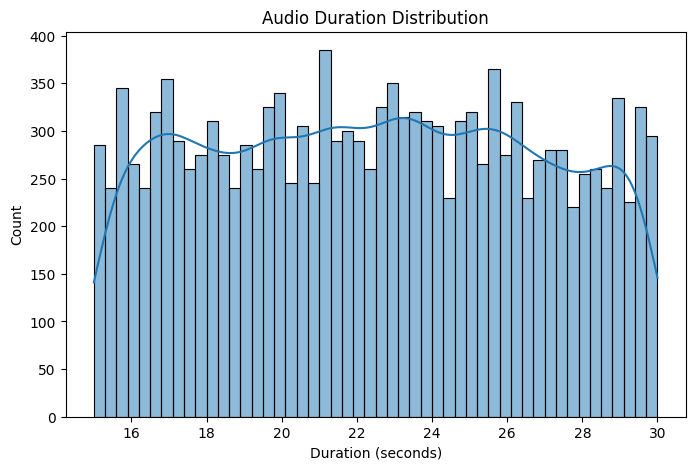

In [12]:
print_audio_duration_distribution(df_metadata)

In [19]:
import time
start = time.time()
silent_90 = [i for i in metadata if i['silence_ratio']]
end = time.time()
print(f"{end - start:.4}")

start = time.time()
silent_90 = [i for i in silent_ if i[1] >= 0.9]
end = time.time()
print(f"{end - start:.4}")

print(f"전체 결과 개수 : {len(silent_)}")

print(len(silent_90))
print(*sorted(silent_90, key=lambda x: (-x[1], x[0]))[:10], sep="\n")

0.001999
0.0009987
전체 결과 개수 : 2893
192
('D:\\work_dir\\data/Clotho/train/Boom_Folie_NoiseOnGlass.wav', 0.9999644886363637)
('D:\\work_dir\\data/Clotho/train/Wet peas.wav', 0.9997985843356161)
('D:\\work_dir\\data/Clotho/train/january birds yorkshire.wav', 0.9987801035903769)
('D:\\work_dir\\data/Clotho/train/Sprinkler 1_R.wav', 0.9979620040993366)
('D:\\work_dir\\data/Clotho/train/Glass_Bottle_Spilling_Liquid.wav', 0.9976310781969194)
('D:\\work_dir\\data/Clotho/train/Creaking and squeaking of old headsets.wav', 0.9974419391238357)
('D:\\work_dir\\data/Clotho/train/CoinSpin.wav', 0.9968291491996951)
('D:\\work_dir\\data/Clotho/train/Padlock.wav', 0.9954529950266273)
('D:\\work_dir\\data/Clotho/train/Filing Nails.wav', 0.9952637299514628)
('D:\\work_dir\\data/Clotho/train/Snapping twig.wav', 0.9951451322887234)
('D:\\work_dir\\data/Clotho/train/mansteps.wav', 0.9930607701091063)
('D:\\work_dir\\data/Clotho/train/metaltap_onglass.wav', 0.9927858397038037)
('D:\\work_dir\\data/Clotho/trai

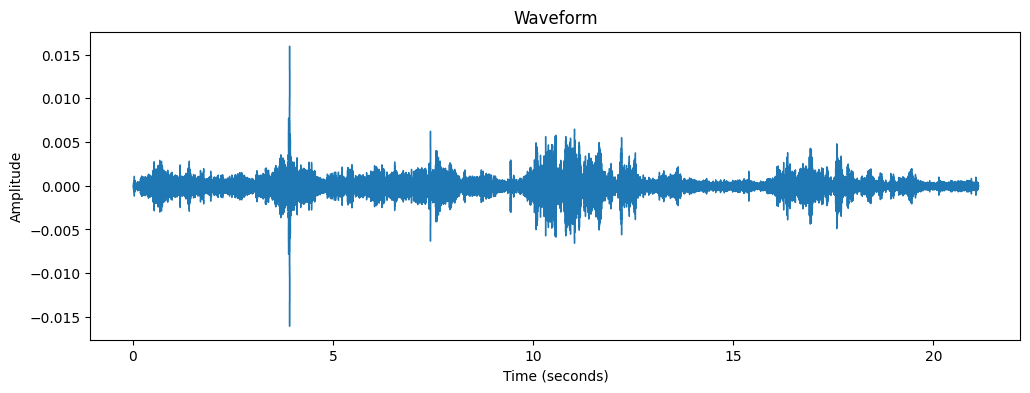

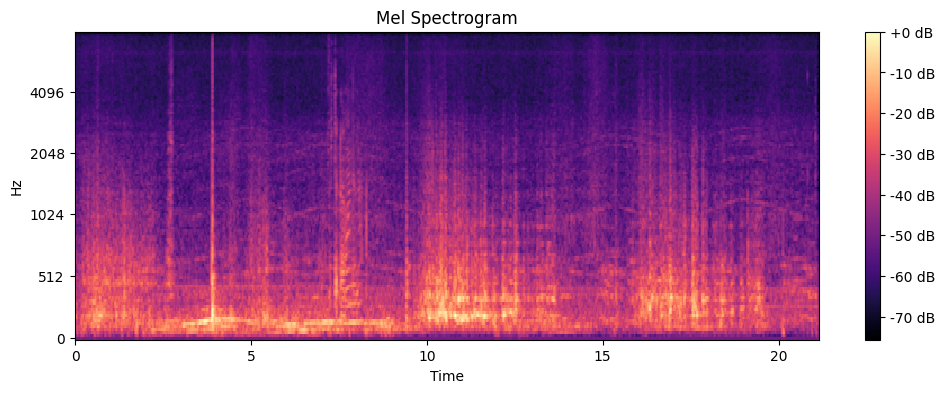

In [20]:
# 파형과 스펙트로그램 확인
# TODO: 어떤 데이터의 파형을 봐야할지 고민 해봐야할 듯. T-SNE로 전체적인 데이터 분포를 보고 판단해야할 수도 있다

file_path = "D:\\work_dir\\data/Clotho/train/Boom_Folie_NoiseOnGlass.wav"
    
print_wav_and_spectogram(file_path)

Extracted feature shape: (2893, 13)


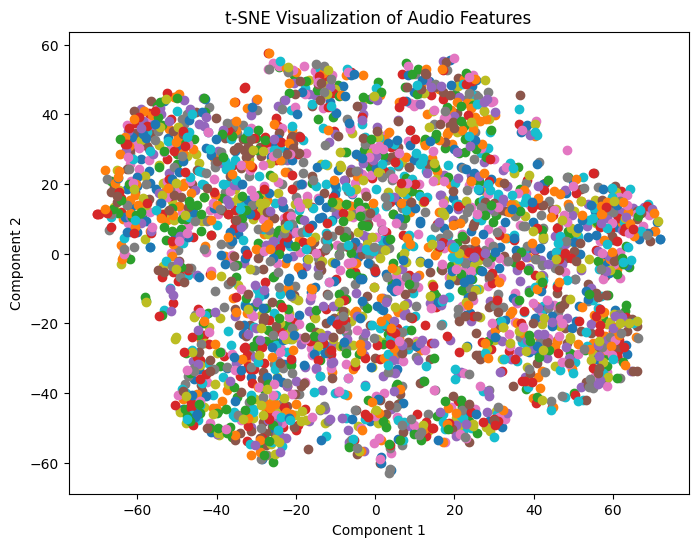

In [22]:

# # 4. 실행 및 분석
wanted = ["Clotho"]

features, labels = load_audio_features(stage1_json, data_prefix, feature_type="mfcc", wanted=wanted)

print("Extracted feature shape:", features.shape)

apply_tsne(features, labels)


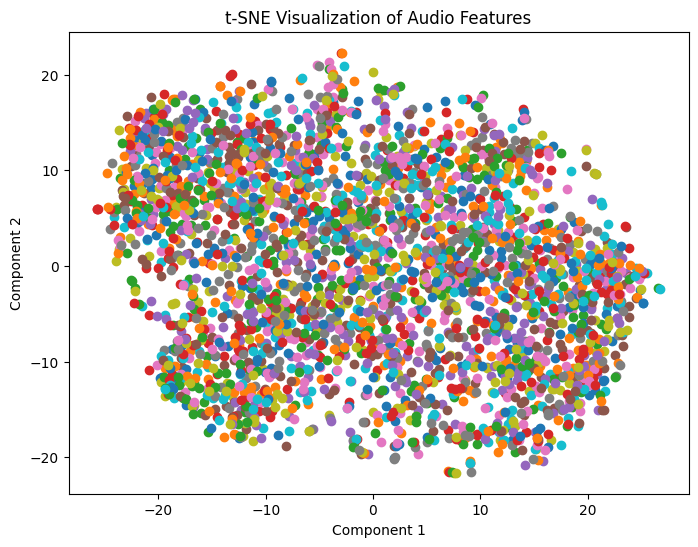

In [23]:
apply_tsne(features, labels, perplexity=100)

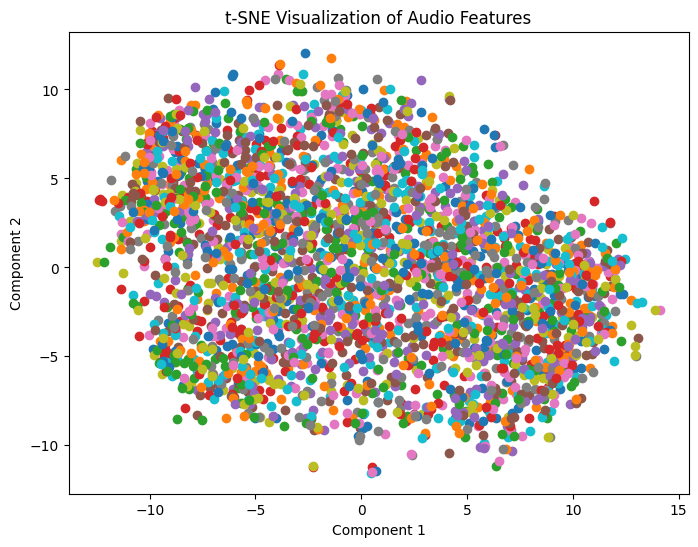

In [24]:
apply_tsne(features, labels, perplexity=250)

Extracted feature shape: (2893, 13)


c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


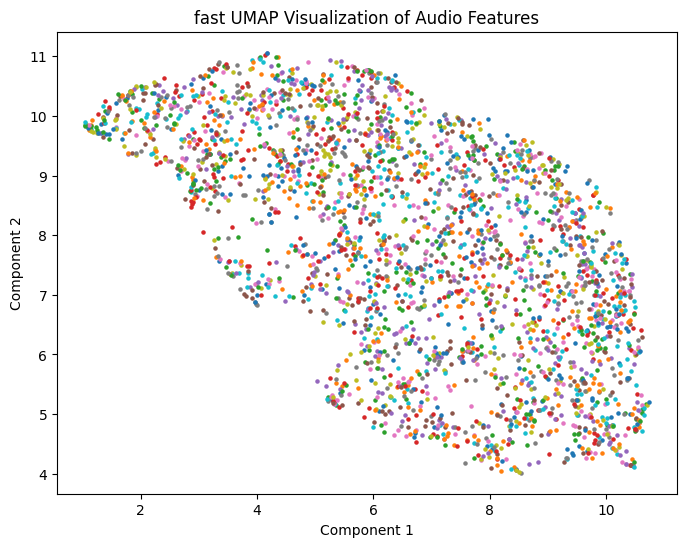

In [17]:
# umap
wanted = ["Clotho"]

features, labels = load_audio_features(stage1_json, data_prefix, feature_type="mfcc", wanted=wanted)

print("Extracted feature shape:", features.shape)

apply_umap(features, labels)

Extracted feature shape: (3983, 13)


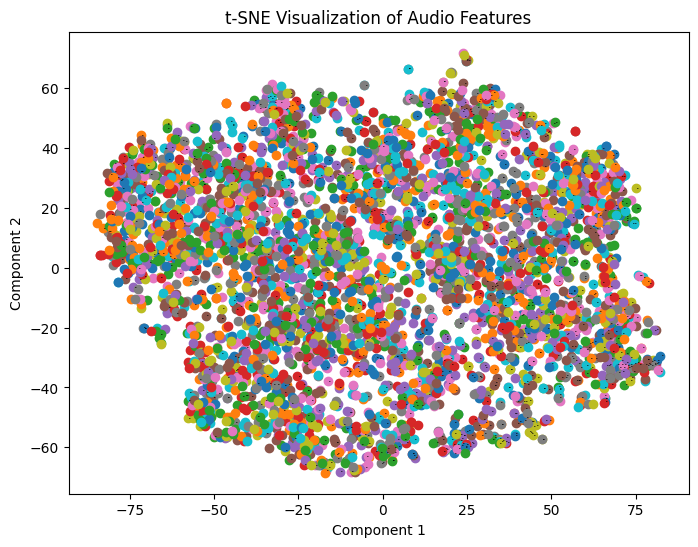

In [61]:
# with Clotho & WavCaps/SoundBible

wanted = ["Clotho", "SoundBible"]

features, labels = load_audio_features(stage1_json, data_prefix, feature_type="mfcc", wanted=wanted)

print("Extracted feature shape:", features.shape)

apply_tsne(features, labels)

c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


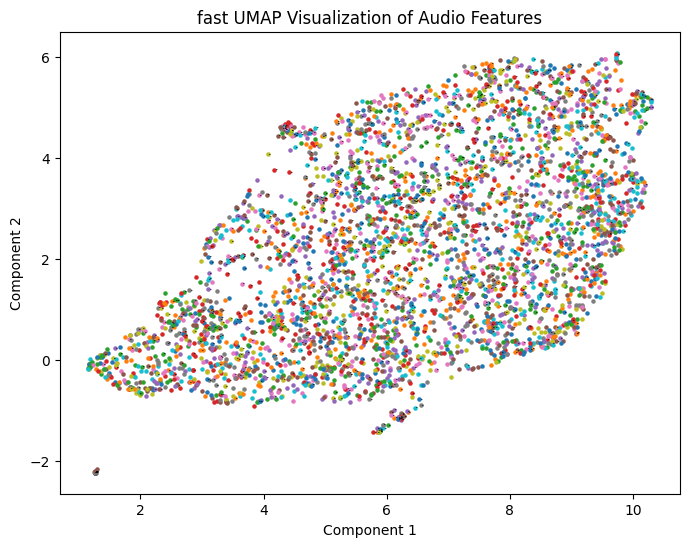

In [19]:
# with Clotho & WavCaps/SoundBible
wanted = ["Clotho", "SoundBible"]

features, labels = load_audio_features(stage1_json, data_prefix, feature_type="mfcc", wanted=wanted)

apply_umap(features, labels)

LibriSpeech

In [27]:
# TODO: 다른 데이터셋도 위 방법과 동일하게 분석해보기
# meta data 분석

wanted = ["LibriSpeech"]

df_metadata, metadata, ann_dict, silent_ = get_metadata_info(stage1_json, data_prefix, wanted)
df_metadata.describe()

sample_rate  channels   duration_sec  silence_ratio
count     281241.0  281241.0  281241.000000  281241.000000
mean       16000.0       1.0      12.301890       0.464435
std            0.0       0.0       3.835131       0.116278
min        16000.0       1.0       0.830000       0.000000
25%        16000.0       1.0      10.625000       0.409274
50%        16000.0       1.0      13.790000       0.469541
75%        16000.0       1.0      15.085000       0.532257
max        16000.0       1.0      29.735000       0.933958

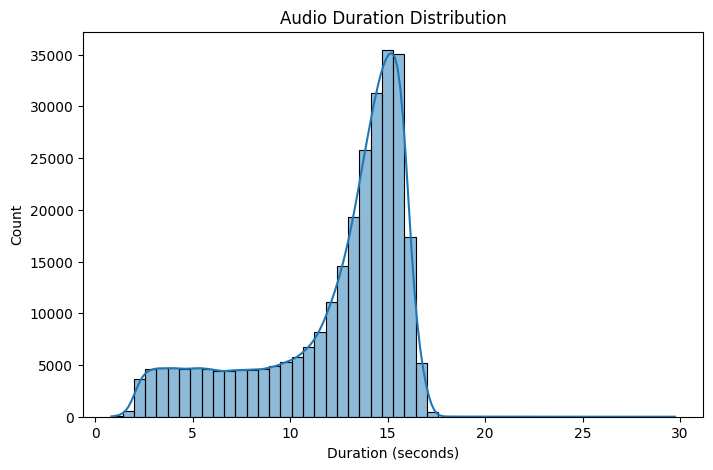

In [28]:
# look at audio-duration distribution
print_audio_duration_distribution(df_metadata)

In [29]:
# 
import time
start = time.time()
silent_90 = [i for i in metadata if i['silence_ratio']]
end = time.time()
print(f"{end - start:.4}")

start = time.time()
silent_90 = [i for i in silent_ if i[1] >= 0.9]
end = time.time()
print(f"{end - start:.4}")

print(f"전체 결과 개수 : {len(silent_)}")

print(len(silent_90))
print(*sorted(silent_90, key=lambda x: (-x[1], x[0]))[:10], sep="\n")

0.033
0.074
전체 결과 개수 : 281241
37
('D:\\work_dir\\data/LibriSpeech/train-clean-360/1383/130533/1383-130533-0014.flac', 0.9339579303675049)
('D:\\work_dir\\data/LibriSpeech/train-other-500/1384/130531/1384-130531-0031.flac', 0.9311306275579809)
('D:\\work_dir\\data/LibriSpeech/train-clean-360/1383/130533/1383-130533-0011.flac', 0.924052700348432)
('D:\\work_dir\\data/LibriSpeech/train-other-500/1384/130531/1384-130531-0029.flac', 0.921839174582378)
('D:\\work_dir\\data/LibriSpeech/train-clean-360/497/129325/497-129325-0011.flac', 0.918967163039328)
('D:\\work_dir\\data/LibriSpeech/train-clean-360/1383/130533/1383-130533-0010.flac', 0.9184053122465531)
('D:\\work_dir\\data/LibriSpeech/train-other-500/2491/134787/2491-134787-0031.flac', 0.9182986111111111)
('D:\\work_dir\\data/LibriSpeech/train-other-500/1384/130531/1384-130531-0014.flac', 0.9169418238993711)
('D:\\work_dir\\data/LibriSpeech/train-other-500/1384/130531/1384-130531-0030.flac', 0.9154666254635352)
('D:\\work_dir\\data/LibriS

Extracted feature shape: (3983, 13)


c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


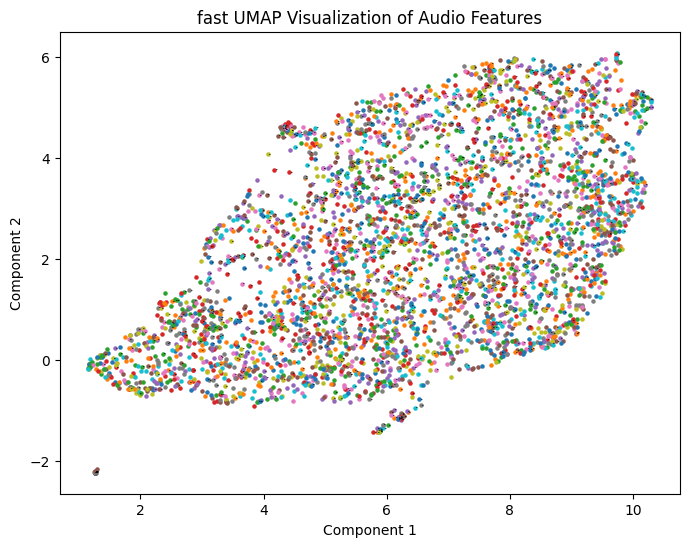

In [20]:
# # 4. 실행 및 분석
wanted = ["LibriSpeech"]

features, labels = load_audio_features(stage1_json, data_prefix, feature_type="mfcc", wanted=wanted)

print("Extracted feature shape:", features.shape)

apply_umap(features, labels)

GigeSpeech

In [21]:
# TODO: 다른 데이터셋도 위 방법과 동일하게 분석해보기
# meta data 분석

wanted = ["GigaSpeech"]

df_metadata, metadata, ann_dict, silent_ = get_metadata_info(stage1_json, data_prefix, wanted)
df_metadata.describe()

C:\Users\Kwak\AppData\Local\Temp\ipykernel_12632\2509813889.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


can't open D:\work_dir\data/GigaSpeech/5/AUD0000001354_S0002464.wav
can't open D:\work_dir\data/GigaSpeech/25/YOU0000007639_S0000124.wav
can't open D:\work_dir\data/GigaSpeech/5/AUD0000001354_S0001797.wav


sample_rate  channels   duration_sec  silence_ratio
count     910137.0  910137.0  910137.000000  910137.000000
mean       16000.0       1.0       3.955234       0.413278
std            0.0       0.0       2.764447       0.150563
min        16000.0       1.0       0.500000       0.014394
25%        16000.0       1.0       2.000000       0.309771
50%        16000.0       1.0       3.210000       0.402135
75%        16000.0       1.0       5.100000       0.503487
max        16000.0       1.0      20.000000       1.000000

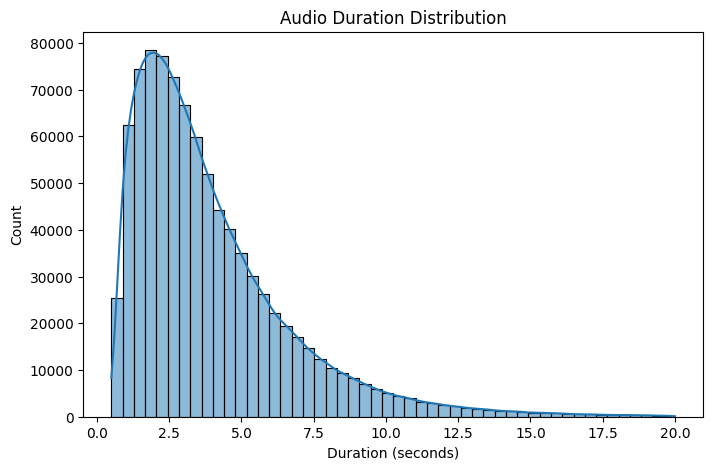

In [22]:
# look at audio-duration distribution
print_audio_duration_distribution(df_metadata)

In [23]:
start = time.time()
silent_90 = [i for i in metadata if i['silence_ratio']]
end = time.time()
print(f"{end - start:.4}")

start = time.time()
silent_90 = [i for i in silent_ if i[1] >= 0.9]
end = time.time()
print(f"{end - start:.4}")

print(f"전체 결과 개수 : {len(silent_)}")

print(len(silent_90))
print(*sorted(silent_90, key=lambda x: (-x[1], x[0]))[:10], sep="\n")

0.183
0.503
전체 결과 개수 : 910137
4415
('D:\\work_dir\\data/GigaSpeech/18/YOU0000000125_S0000604.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/18/YOU0000000825_S0000129.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/18/YOU0000000825_S0000130.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/18/YOU0000000991_S0000110.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/19/YOU0000001249_S0000715.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/19/YOU0000001253_S0000016.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/19/YOU0000001561_S0000172.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/19/YOU0000001627_S0000121.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/19/YOU0000001627_S0000122.wav', 1.0)
('D:\\work_dir\\data/GigaSpeech/19/YOU0000001627_S0000123.wav', 1.0)


In [10]:
# # 4. 실행 및 분석
wanted = ["GigaSpeech"]

features, labels = load_audio_features(stage1_json, data_prefix, feature_type="mfcc", wanted=wanted)

In [11]:
print("Extracted feature shape:", features.shape)

Extracted feature shape: (910140, 13)


In [13]:
# testing different methods to analysize big data 
# 표준화 (t-SNE는 거리 기반이므로 중요)
start = time.time()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print(f"{time.time() - start}")
# n_components  : 차원 축소 후 출력 차원의 수 (보통 2D or 3D를 사용한다고 함)
# perplexity    : T-SNE에서 개별 데이터 포인트의 근접 이웃 수를 결정하는 하이퍼파라미터 / 데이터의 밀도를 나타내며, 적절한 값이 모델 성능에 중요한 영향을 미침 / 클러스터링의 밸런스 조정하는 역할
#                 작은 값 (5 ~ 10) : 지역적인 구조 파아겡 적합, 큰 값 (50~100) : 전역적인 구조 파악에 적합, gpt추천은 데이터 샘플 수의 1/3 1/10 범위에서 조정하라고 함
# max_iter      : T-SNE 알고리즘이 최적의 저차원 표현을 찾기 위해 수행하는 최대 반복 횟수, 작은 데이텃세 : 300~500, 복자한 데이터 : 1000~5000 

start = time.time()
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embedded = umap_reducer.fit_transform(features_scaled)
print(f"{time.time() - start}")

0.21700048446655273


c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


1343.435572385788


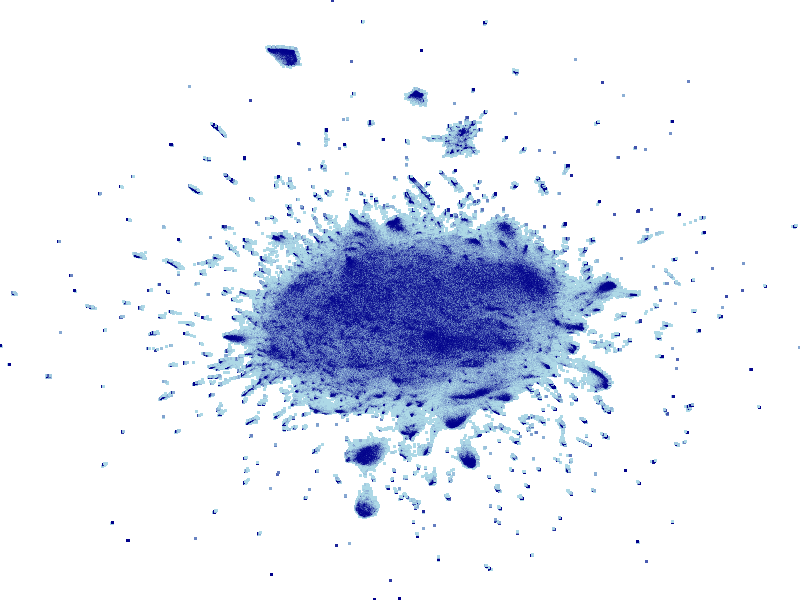

In [18]:
df = pd.DataFrame(embedded, columns=["x", "y"])
canvas = ds.Canvas(plot_width=800, plot_height=600)
agg = canvas.points(df, 'x', 'y')

# img = tf.shade(agg)
img = tf.spread(tf.shade(agg), px=1)  # 기본값 1 → 3픽셀로 확대#
img

In [ ]:

apply_umap_with_ds(features, labels) # previous method, with just pyplot => too slow for big data


WavCaps

In [21]:
# TODO: 다른 데이터셋도 위 방법과 동일하게 분석해보기
# meta data 분석

wanted = ["WavCaps"]

df_metadata, metadata, ann_dict, silent_ = get_metadata_info(stage1_json, data_prefix, wanted)
df_metadata.describe()

sample_rate  channels   duration_sec  silence_ratio
count     367712.0  367712.0  367712.000000  367712.000000
mean       16000.0       1.0      27.764372       0.465774
std            0.0       0.0      36.254608       0.317466
min        16000.0       1.0       0.473500       0.000000
25%        16000.0       1.0       9.084984       0.171359
50%        16000.0       1.0      10.000000       0.419799
75%        16000.0       1.0      31.937500       0.756468
max        16000.0       1.0     180.000000       1.000000

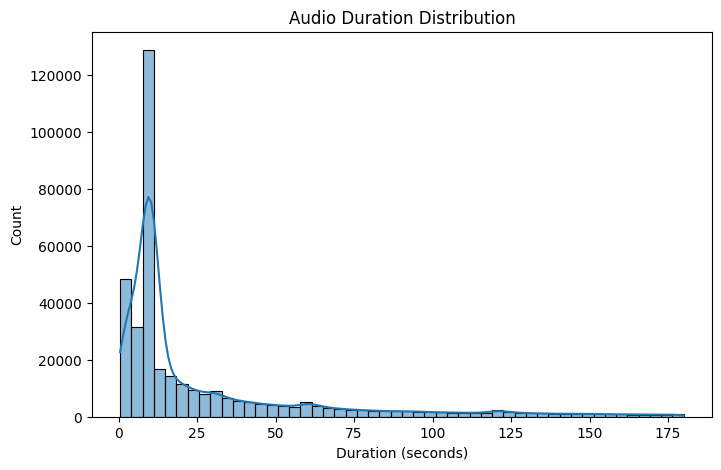

In [22]:
# look at audio-duration distribution
print_audio_duration_distribution(df_metadata)

In [23]:
start = time.time()
silent_90 = [i for i in metadata if i['silence_ratio']]
end = time.time()
print(f"{end - start:.4}")

start = time.time()
silent_90 = [i for i in silent_ if i[1] >= 0.9]
end = time.time()
print(f"{end - start:.4}")

print(f"전체 결과 개수 : {len(silent_)}")

print(len(silent_90))
print(*sorted(silent_90, key=lambda x: (-x[1], x[0]))[:10], sep="\n")

0.055
0.114
전체 결과 개수 : 367712
51643
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y-4E4LnOdK7s.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y05oYRUh2eQ8.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y09DkZDMByIE.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y0AXl8mKEd90.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y0qucA5OlN2o.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y0wVH8azj0CI.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y1pZr5R0oWDs.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y22BhvrMm0g4.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y299JlKDvRMY.flac', 1.0)
('D:\\work_dir\\data/WavCaps/AudioSet_SL/Y2R31fl0FGWg.flac', 1.0)


Extracted feature shape: (367712, 13)


c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


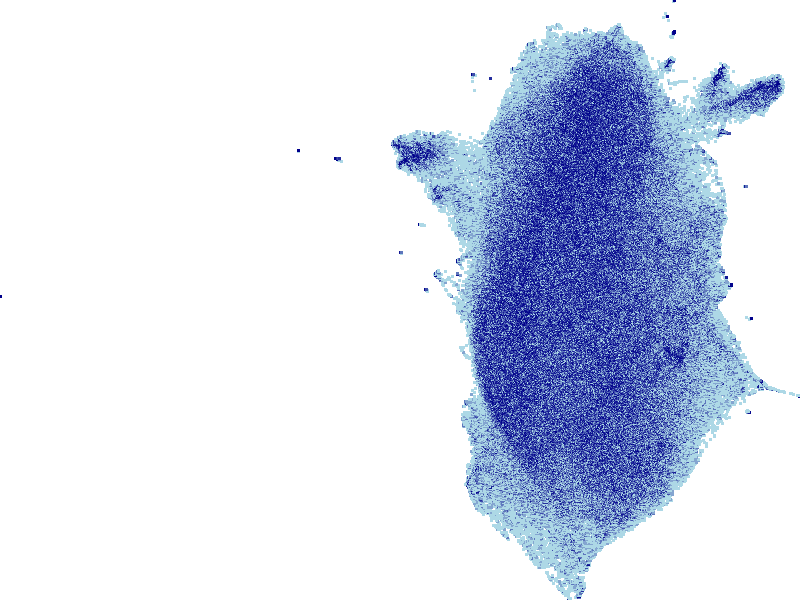

In [24]:
# # 4. 실행 및 분석

features, labels = load_audio_features(stage1_json, data_prefix, feature_type="mfcc", wanted=wanted)

print("Extracted feature shape:", features.shape)

apply_umap_with_ds(features, labels)

#### 전체 데이터셋 분포

### Stage2

#### Audiocaps

In [22]:
# TODO: Stage2 Metadata 분석
stage2_json = read_json(stage2_train)


In [10]:
print(stage2_json.keys())
print(f"total number of audio-text pairs : {len(stage2_json['annotation'])}")

dict_keys(['annotation'])
total number of audio-text pairs : 1403890


In [11]:
stage2_json["annotation"][0:3]

[{'path': 'GigaSpeech/16/POD0000010316_S0000117.wav',
  'text': 'And like staring down the barrel of this coming school year, like the end of summer and is thinking of quitting or putting their career on hold because of their kids.',
  'task': 'asr'},
 {'path': '/LibriSpeech/train-clean-100/6836/61803/6836-61803-0003.flac',
  'text': 'Maurice Gerald',
  'task': 'QA',
  'Q': 'Who has been acquitted?'},
 {'path': '/LibriSpeech/train-clean-100/8425/246962/8425-246962-0000.flac',
  'text': 'Leopold lay wound in the net of a low fever almost as ill as ever.',
  'task': 'QA',
  'Q': "What was Leopold's condition before morning?"}]

In [12]:
total_count, each_count, file_paths = count_num_of_data(stage2_json, ["audiocaps", "Clotho", "GigaSpeech", "LibriSpeech", "MusicNet", "WavCaps"], output_with_file_path=False)

print(f"stage1 total audio num : {total_count}")
print(each_count)

stage1 total audio num : 801503
{'audiocaps': 46647, 'Clotho': 2893, 'GigaSpeech': 200000, 'LibriSpeech': 281241, 'MusicNet': 320, 'WavCaps': 270402}


In [13]:
# meta data 분석

wanted = ["audiocaps"]

df_metadata, metadata, ann_dict, silent_ = get_metadata_info(stage2_json, data_prefix, wanted)
df_metadata.describe()

C:\Users\Kwak\AppData\Local\Temp\ipykernel_36800\2509813889.py:21: RuntimeWarning: invalid value encountered in scalar divide
  silence_ratio = np.sum(np.abs(audio) < silence_threshold) / len(audio)


sample_rate      channels  duration_sec  silence_ratio
count      46647.0  46647.000000  46647.000000   46644.000000
mean       16000.0      1.967265     42.914097       0.367428
std            0.0      0.352529     20.859013       0.277694
min        16000.0      1.000000      0.000000       0.000000
25%        16000.0      2.000000     20.968000       0.120404
50%        16000.0      2.000000     60.000000       0.300505
75%        16000.0      2.000000     60.000000       0.571953
max        16000.0      6.000000     60.000000       1.000000

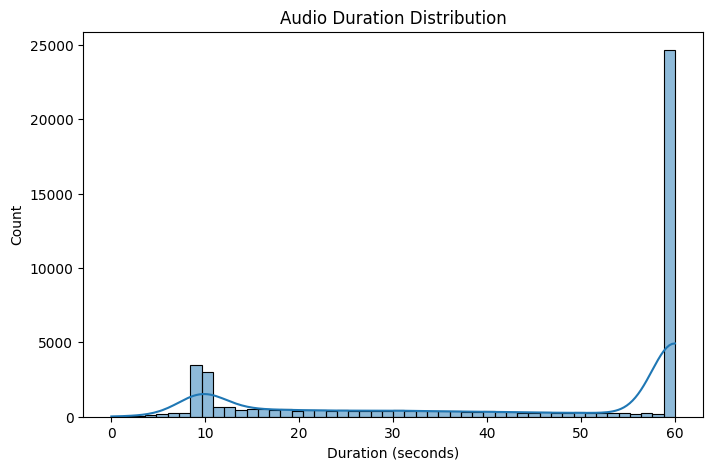

In [14]:
# look at audio-duration distribution
print_audio_duration_distribution(df_metadata)

In [15]:
start = time.time()
silent_90 = [i for i in metadata if i['silence_ratio']]
end = time.time()
print(f"{end - start:.4}")

start = time.time()
silent_90 = [i for i in silent_ if i[1] >= 0.9]
end = time.time()
print(f"{end - start:.4}")

print(f"전체 결과 개수 : {len(silent_)}")

print(len(silent_90))
print(*sorted(silent_90, key=lambda x: (-x[1], x[0]))[:10], sep="\n")

0.017
0.019
전체 결과 개수 : 46647
2497
('D:\\work_dir\\data/audiocaps_1m/train/100184.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/12995.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/15104.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/18537.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/22768.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/2603.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/42081.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/51935.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/53893.wav', 1.0)
('D:\\work_dir\\data/audiocaps_1m/train/6768.wav', 1.0)


c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Extracted feature shape: (46647, 13)


c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


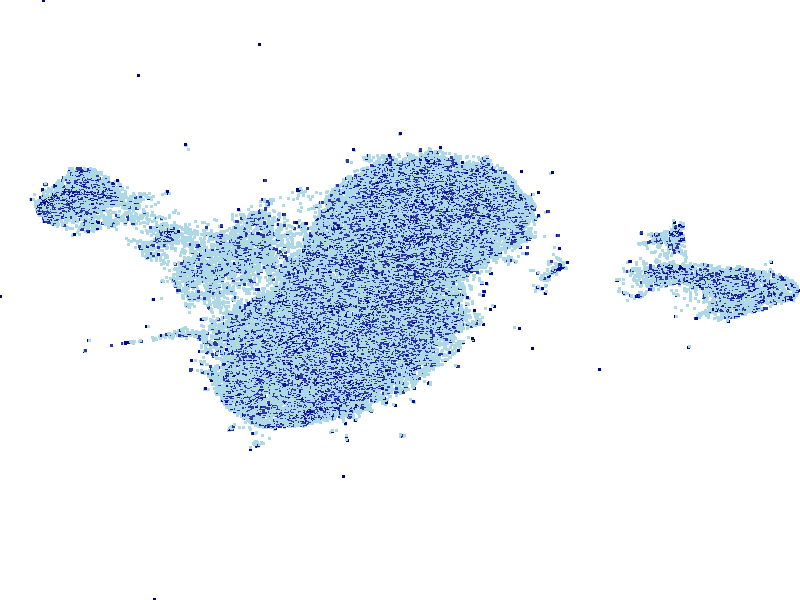

In [16]:
# # 4. 실행 및 분석

features, labels = load_audio_features(stage2_json, data_prefix, feature_type="mfcc", wanted=wanted)

print("Extracted feature shape:", features.shape)

apply_umap_with_ds(features, labels)

#### MusicNet

In [99]:
# meta data 분석

wanted = ["MusicNet"]

df_metadata, metadata, ann_dict, silent_ = get_metadata_info(stage2_json, data_prefix, wanted)
df_metadata.describe()

sample_rate  channels  duration_sec  silence_ratio
count        320.0     320.0    320.000000     320.000000
mean       16000.0       1.0    379.336798       0.303223
std            0.0       0.0    194.498989       0.121520
min        16000.0       1.0     55.249000       0.059077
25%        16000.0       1.0    231.542891       0.213853
50%        16000.0       1.0    356.623719       0.288709
75%        16000.0       1.0    481.064500       0.375431
max        16000.0       1.0   1069.035125       0.735109

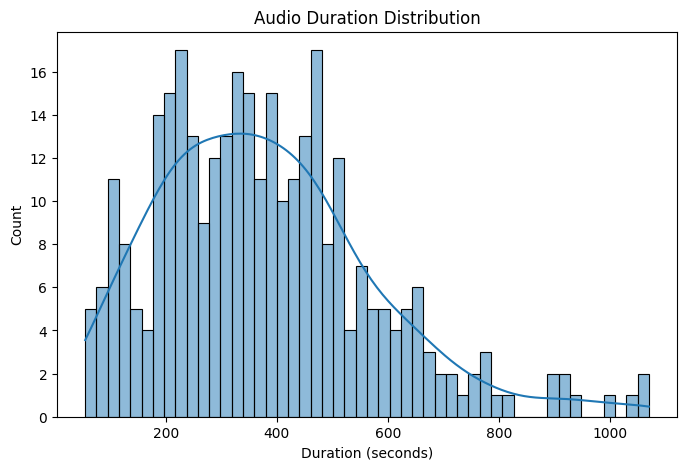

In [100]:
# look at audio-duration distribution
print_audio_duration_distribution(df_metadata)

Extracted feature shape: (320, 13)


c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


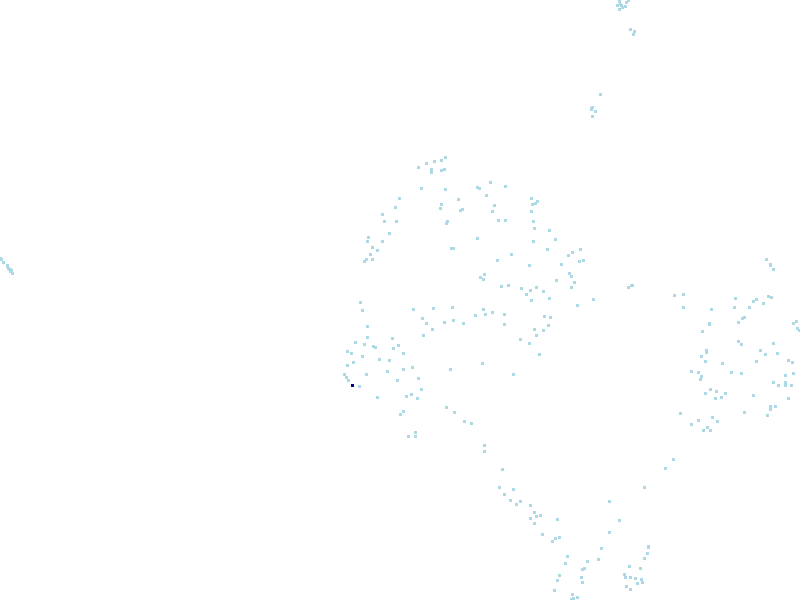

In [101]:
# # 4. 실행 및 분석

features, labels = load_audio_features(stage2_json, data_prefix, feature_type="mfcc", wanted=wanted)

print("Extracted feature shape:", features.shape)

apply_umap_with_ds(features, labels)

### Test dataset

In [104]:
test_asr_json = read_json(test_asr)
test_aac_json = read_json(test_aac)

In [106]:
get_tasks(test_asr_json)
get_tasks(test_aac_json)

{'LibriSpeech': {'asr': 2939}}
{'asr': 2939}
{'audiocaps': {'audiocaption_v2': 4355}}
{'audiocaption_v2': 4355}


In [107]:
wanted = ["LibriSpeech"]
df_test_asr_metadata, test_asr_metadata, test_asr_silent = get_metadata_info(test_asr_json, data_prefix, wanted, silence_threshold=0.0001, is_train=False)
wanted = ["audiocaps"]
df_test_aac_metadata, test_aac_metadata, test_aac_silent = get_metadata_info(test_aac_json, data_prefix, wanted, silence_threshold=0.0001, is_train=False)

sample_rate     channels  duration_sec  silence_ratio
count   4355.000000  4355.000000   4355.000000    4355.000000
mean   16036.739380     1.951780     44.028732       0.039589
std     1083.780461     0.371181     20.460582       0.104840
min    16000.000000     1.000000      1.749000       0.000096
25%    16000.000000     2.000000     23.568000       0.001976
50%    16000.000000     2.000000     60.000000       0.006539
75%    16000.000000     2.000000     60.000000       0.022714
max    48000.000000     6.000000     60.000000       0.943080

In [108]:
print("result of test_asr metadata")
df_test_asr_metadata.describe()

result of test_asr metadata


sample_rate  channels  duration_sec  silence_ratio
count       2939.0    2939.0   2939.000000    2939.000000
mean       16000.0       1.0      6.542896       0.059757
std            0.0       0.0      4.427100       0.075052
min        16000.0       1.0      1.250000       0.000481
25%        16000.0       1.0      3.412469       0.010857
50%        16000.0       1.0      5.150000       0.025766
75%        16000.0       1.0      8.215000       0.082321
max        16000.0       1.0     34.510000       0.529258

In [109]:
print("result of test_aac metadata")
df_test_aac_metadata.describe()

result of test_aac metadata


sample_rate     channels  duration_sec  silence_ratio
count   4355.000000  4355.000000   4355.000000    4355.000000
mean   16036.739380     1.951780     44.028732       0.039589
std     1083.780461     0.371181     20.460582       0.104840
min    16000.000000     1.000000      1.749000       0.000096
25%    16000.000000     2.000000     23.568000       0.001976
50%    16000.000000     2.000000     60.000000       0.006539
75%    16000.000000     2.000000     60.000000       0.022714
max    48000.000000     6.000000     60.000000       0.943080

In [ ]:
# TODO: save silent samples info
def create_silent_csv(csv_path: str, metadata: list, silent_ratio: float=None, create: bool=True, sort_by: str="silence_ratio", ascending: bool=False):
    if silent_ratio:
        metadata = [i for i in metadata if i['silence_ratio'] >= silent_ratio]
    
    if not(metadata):
        print(f"no metadata above silence_ratio={silent_ratio}")
        return
    
    df = pd.DataFrame(metadata)
    
    if os.path.exists(csv_path) and not(create):
        df_exist = pd.read_csv(csv_path)
        df = pd.concat([df_exist, df], ignore_index=True)
        print(f"appended metadata into csv file at {csv_path}")
    else:
        print(f"created new csv file at {csv_path}")
    
    df = df.sort_values(by=sort_by, ascending=ascending)
    df.to_csv(csv_path, index=False, encoding="UTF-8")


In [27]:
# create_silent_csv("asdasd.csv", metadata, silent_ratio=0.9, create=False, sort_by="silence_ratio", ascending=False)

appended metadata into csv file at asdasd.csv


In [9]:
# create audio metadata csv files

data_prefix = "D:\\work_dir\\data"

data_paths = {"stage1_train": "D:\\work_dir\\data\\stage1_train.json",
              "stage2_train": "D:\\work_dir\\data\\stage2_train.json"}

data_paths = {"test_asr": "D:\\work_dir\\data\\test_asr.json",
              "test_aac": "D:\\work_dir\\data\\test_aac.json"}

wanted_list = ["audiocaps", "Clotho", "GigaSpeech", "LibriSpeech", "MusicNet", "WavCaps"]

silence_threshold = 0.0001
silent_ratio = 0.5

for k, v in data_paths.items():
    print(f"extracting meta data from {k}")
    stagei_json = read_json(v)
    
    for wanted in wanted_list:
        wanted = [wanted]
        df_metadata, metadata, ann_dict, silent_ = get_metadata_info(stagei_json, data_prefix, wanted, silence_threshold=silence_threshold, is_train=False)
        
        if metadata:
            create_silent_csv(data_prefix + f"\\{k}_audio_metadata_v2.csv", metadata, create=False)
            # create_silent_csv(data_prefix + f"\\{k}_audio_metadata50_v2.csv", metadata, create=False, silent_ratio=silent_ratio)
        else:
            print(f"metadata is empty. skipping {wanted} dataset.")

extracting meta data from test_asr
metadata is empty. skipping ['audiocaps'] dataset.
metadata is empty. skipping ['Clotho'] dataset.
metadata is empty. skipping ['GigaSpeech'] dataset.
created new csv file at D:\work_dir\data\test_asr_audio_metadata_v2.csv
metadata is empty. skipping ['MusicNet'] dataset.
metadata is empty. skipping ['WavCaps'] dataset.
extracting meta data from test_aac
created new csv file at D:\work_dir\data\test_aac_audio_metadata_v2.csv
metadata is empty. skipping ['Clotho'] dataset.
metadata is empty. skipping ['GigaSpeech'] dataset.
metadata is empty. skipping ['LibriSpeech'] dataset.
metadata is empty. skipping ['MusicNet'] dataset.
metadata is empty. skipping ['WavCaps'] dataset.


In [27]:

# filtered_json["annotation"] = [i for i in stage1_json["annotation"] if i["path"] not in filtered_metadata]

def get_filtered_json_with_csv(metadata_csv_path: str, ann_json: dict, key: str, threshold: Union[float, int]) -> dict:
    filtered_json = dict()
    
    metadata = pd.read_csv(metadata_csv_path)
    
    filtered_metadata = set(metadata[metadata[key] >= threshold]["filename"])
    
    filtered_json["annotation"] = [i for i in ann_json["annotation"] if add_slash_if_needed(i["path"]) not in filtered_metadata]

    return filtered_json

def save_json(data: dict, data_prefix: str, output_filename: str) -> None:
    output_path = combine_path(data_prefix, output_filename)

    with open(output_path, "w", encoding="UTF-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)
        
def combine_path(prefix: str, path: str) -> str:
    return prefix + path if path.startswith("/") else prefix + "/" + path

def add_slash_if_needed(path: str) -> str:
    return path if path.startswith("/") else "/" + path


In [28]:
csv_path = "D:\\work_dir\\data\\stage2_train_audio_metadata_v2.csv"
k = "silence_ratio"
k_threshold = 0.975
output_filename = "stage2_train_filtered_silence_0001_ratio_0975.json"

filtered_json = get_filtered_json_with_csv(csv_path, stage2_json, k, k_threshold)
save_json(filtered_json, data_prefix, output_filename)

In [59]:
print(len(filtered_json["annotation"]))
print(len(stage1_json["annotation"]))

1537434
1573558


In [11]:
# TODO: listen to data to find the great k_threshold, maybe check their mel spectogram might be great
filtered_json

{'annotation': [{'path': '/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac',
   'text': 'Chapter one missus rachel lynde is surprised missus rachel lynde lived just where the avonlea main road dipped down into a little hollow fringed with alders and ladies eardrops and traversed by a brook',
   'task': 'asr'},
  {'path': '/LibriSpeech/train-clean-100/103/1240/103-1240-0001.flac',
   'text': "That had its source away back in the woods of the old cuthbert place it was reputed to be an intricate headlong brook in its earlier course through those woods with dark secrets of pool and cascade but by the time it reached lynde's hollow it was a quiet well conducted little stream",
   'task': 'asr'},
  {'path': '/LibriSpeech/train-clean-100/103/1240/103-1240-0002.flac',
   'text': "For not even a brook could run past missus rachel lynde's door without due regard for decency and decorum it probably was conscious that missus rachel was sitting at her window keeping a sharp eye on everythin

In [32]:
def get_ann(ann_json: dict, path: str):
    
    for i in ann_json["annotation"]:
        p = i["path"]
        if path == p:
            if i["task"] == "QA":
                print(i["task"], f"Q: {i['Q']} A: {i['text']}", sep=" : ")
            else:
                print(i["task"], i["text"], sep=" : ")
    
def get_tasks(ann_json: dict):
    tasks = dict()
    dataset_tasks = dict()
    
    for i in ann_json["annotation"]:
        if i["task"] not in tasks.keys():
            tasks[i["task"]] = 1
        else:
            tasks[i["task"]] += 1
        
        d = add_slash_if_needed(i["path"]).split("/")[1] 
        if d not in dataset_tasks.keys():
            dataset_tasks[d] = dict()
        
        if i["task"] not in dataset_tasks[d].keys():
            dataset_tasks[d][i["task"]] = 1
        else:
            dataset_tasks[d][i["task"]] += 1
            
    print(dataset_tasks)
    print(tasks)

In [14]:
# stage1_json = read_json(stage1_train)
stage2_json = read_json(stage2_train)

In [75]:

for i in stage2_json["annotation"]:
    
    
    

[{'path': 'GigaSpeech/16/POD0000010316_S0000117.wav',
  'text': 'And like staring down the barrel of this coming school year, like the end of summer and is thinking of quitting or putting their career on hold because of their kids.',
  'task': 'asr'},
 {'path': '/LibriSpeech/train-clean-100/6836/61803/6836-61803-0003.flac',
  'text': 'Maurice Gerald',
  'task': 'QA',
  'Q': 'Who has been acquitted?'},
 {'path': '/LibriSpeech/train-clean-100/8425/246962/8425-246962-0000.flac',
  'text': 'Leopold lay wound in the net of a low fever almost as ill as ever.',
  'task': 'QA',
  'Q': "What was Leopold's condition before morning?"},
 {'path': '/LibriSpeech/train-other-500/4969/73975/4969-73975-0033.flac',
  'text': 'The choice between right and wrong placing appeared to the speaker.',
  'task': 'QA',
  'Q': 'What appeared to the speaker?'},
 {'path': '/LibriSpeech/train-other-500/3657/182397/3657-182397-0017.flac',
  'text': "Cleared his throat as if to begin but for a long time he didn't say 

In [72]:
get_tasks(stage1_json)
get_tasks(stage2_json)

{'LibriSpeech': {'asr': 281241}, 'GigaSpeech': {'asr': 910140}, 'WavCaps': {'audiocaption': 367712}, 'Clotho': {'audiocaption': 14465}}
{'asr': 1191381, 'audiocaption': 382177}
{'GigaSpeech': {'asr': 200000}, 'LibriSpeech': {'QA': 281037, 'asr': 281241, 'phone_recognition': 281239, 'gender_recognition': 28539}, 'WavCaps': {'QA': 270402}, 'audiocaps_1m': {'audiocaption_v2': 46647}, 'Clotho': {'audiocaption_v2': 14465}, 'MusicNet': {'QA': 320}}
{'asr': 481241, 'QA': 551759, 'phone_recognition': 281239, 'audiocaption_v2': 61112, 'gender_recognition': 28539}


audiocaption : Mouth is being opened and closed slowly with the tongue being taken away from the roof of the mouth.
QA : Q: What is happening to the mouth? A: The mouth is being opened and closed slowly with the tongue being taken away from the roof of the mouth.


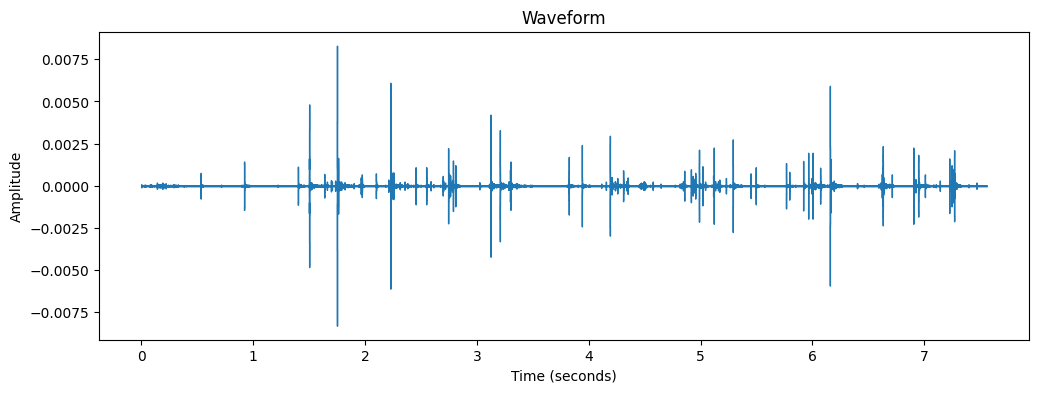

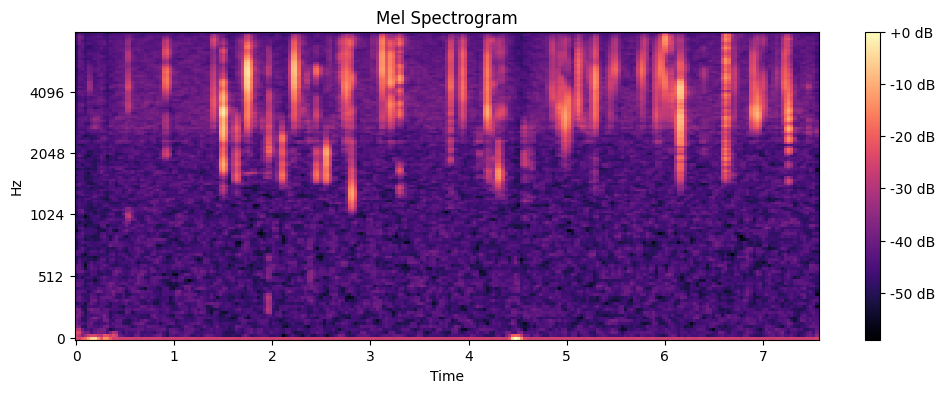

In [22]:
p1 = "/WavCaps/FreeSound/120000-150000/362995.flac"
audio_path = data_prefix + add_slash_if_needed(p1)
get_ann(stage1_json, p1)
get_ann(stage2_json, p1)
print_wav_and_spectogram(audio_path)

/WavCaps/FreeSound/150000-180000/498049.flac
audiocaption : A large dog is yawing.


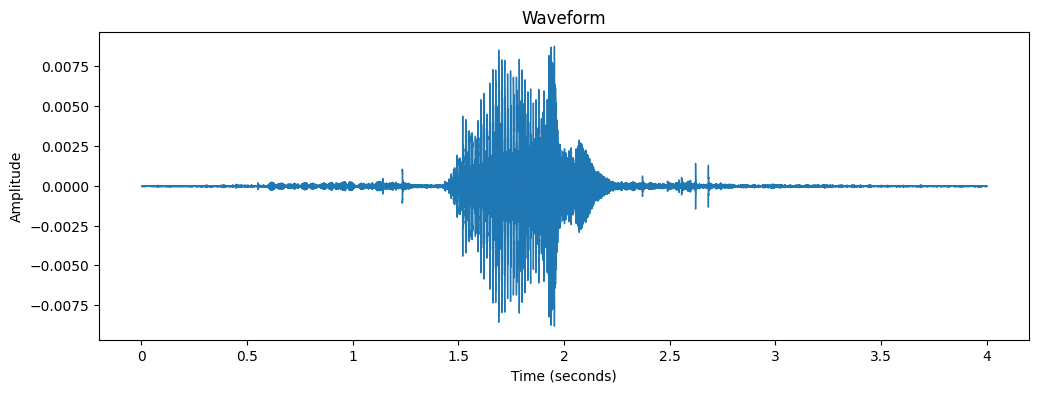

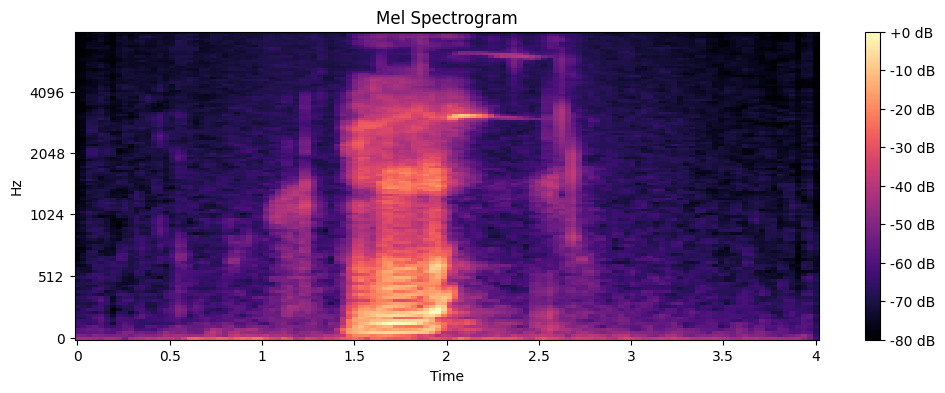

In [ ]:
from IPython.display import clear_output
p1 = "/WavCaps/AudioSet_SL/Y6wtUZBZIjBs.flac"
audio_path = data_prefix + add_slash_if_needed(p1)

df = pd.read_csv("D:\work_dir\data\stage1_train_audio_metadata.csv")

filtered_df = df[df[""]]

for i in df["filename"]:
    print(i)
    
    audio_path = data_prefix + add_slash_if_needed(i)
    get_ann(stage1_json, i)
    print_wav_and_spectogram(audio_path)
    
    a = input()
    if a != "":
        break
    clear_output(wait=True)
    

In [13]:
df.describe()

c:\Users\Kwak\anaconda3\envs\salmonn_env\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


sample_rate   channels  duration_sec  silence_ratio           snr  \
count    1561986.0  1561986.0  1.561986e+06   1.561986e+06  1.561986e+06   
mean       16000.0        1.0  1.109732e+01   4.352556e-02           inf   
std            0.0        0.0  2.030218e+01   8.372307e-02           NaN   
min        16000.0        1.0  4.735000e-01   0.000000e+00 -4.659477e-06   
25%        16000.0        1.0  2.640000e+00   6.303419e-03  0.000000e+00   
50%        16000.0        1.0  5.260000e+00   1.618058e-02  5.177193e-07   
75%        16000.0        1.0  1.120000e+01   4.351687e-02  3.106315e-06   
max        16000.0        1.0  1.800000e+02   1.000000e+00           inf   

           flatness           rms  
count  1.561986e+06  1.561986e+06  
mean   3.981622e-02  6.238832e-02  
std    5.546373e-02  5.194097e-02  
min    2.095595e-10  0.000000e+00  
25%    1.581314e-02  3.238122e-02  
50%    2.736081e-02  5.045560e-02  
75%    4.378307e-02  7.945184e-02  
max    1.000001e+00  9.995140e-01

audiocaption : A heavy engine rumbles.
QA : Q: What sound does the engine make? A: The engine rumbles.


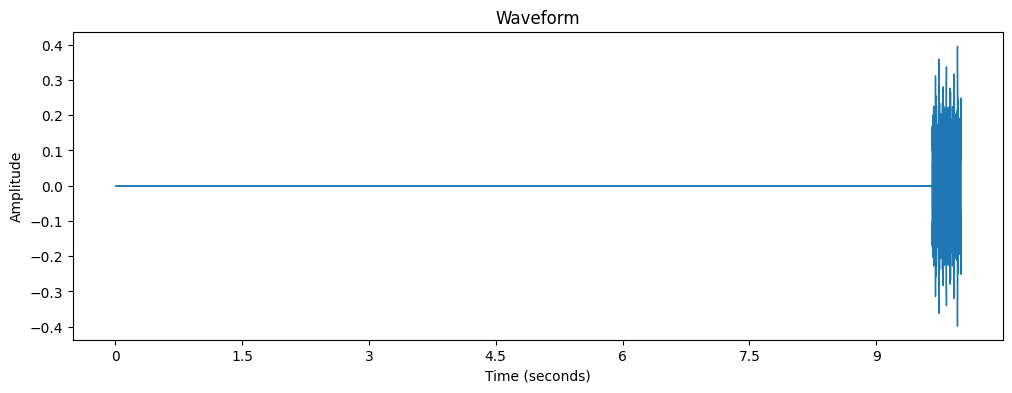

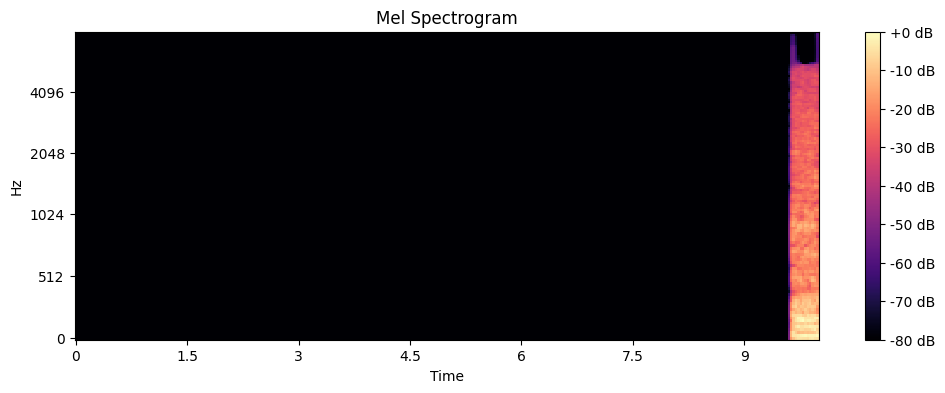

None


In [23]:
from IPython.display import clear_output

df = pd.read_csv("D:\work_dir\data\stage1_train_audio_metadata_v2.csv")

filtered_df = df.sort_values(by=["flatness"], axis=0, ascending=False)

v = 140

i = filtered_df.iloc[v]["filename"]

audio_path = data_prefix + add_slash_if_needed(i)

get_ann(stage1_json, i)
get_ann(stage2_json, i)
print(print_wav_and_spectogram(audio_path))

# for i in filtered_df["filename"]:
#     print(i)
    
#     audio_path = data_prefix + add_slash_if_needed(i)
#     get_ann(stage1_json, i)
#     print_wav_and_spectogram(audio_path)
    
#     a = input()
#     if a != "":
#         break
#     clear_output(wait=True)
    

In [ ]:
# TODO; json file with improved silent samples
def create_json_with_improved_silent_samples():
    pass

In [25]:
# TODO: using CLAP to measure the matching score(sim) between audio and text
# needed to be check if its alright to use or not

import torch
from transformers import AutoProcessor, AutoModel
import librosa
import numpy as np
from scipy.spatial.distance import cosine

class CLAPMatcher:
    def __init__(self, model_name="laion/larger_clap_general"):
        """
        CLAP 모델을 로드하고 오디오 및 텍스트를 처리할 준비를 함.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.processor = AutoProcessor.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()

    def get_audio_embedding(self, audio_path):
        """
        주어진 오디오 파일을 CLAP 임베딩 벡터로 변환.
        """
        # 오디오 로드
        y, sr = librosa.load(audio_path, sr=48000)  # CLAP은 48kHz를 사용
        inputs = self.processor(audios=y, sampling_rate=sr, return_tensors="pt").to(self.device)
        
        # 오디오 임베딩 계산
        with torch.no_grad():
            audio_embeds = self.model.get_audio_features(**inputs).cpu().numpy()

        return audio_embeds

    def get_text_embedding(self, text):
        """
        주어진 텍스트를 CLAP 임베딩 벡터로 변환.
        """
        inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True).to(self.device)

        # 텍스트 임베딩 계산
        with torch.no_grad():
            text_embeds = self.model.get_text_features(**inputs).cpu().numpy()

        return text_embeds

    def calculate_similarity(self, audio_path, text):
        """
        오디오 파일과 텍스트의 매칭 점수를 계산하여 반환.
        """
        audio_emb = self.get_audio_embedding(audio_path)
        text_emb = self.get_text_embedding(text)

        # 코사인 유사도 계산
        similarity_score = 1 - cosine(audio_emb.flatten(), text_emb.flatten())

        return similarity_score

# # 사용 예시
# audio_file = data_prefix + "/WavCaps/AudioSet_SL/Y6wtUZBZIjBs.flac"
# text_description = "Cats are purring, meowing and caterwauling, with laughter and a mechanical fan."

# clap_matcher = CLAPMatcher()
# similarity = clap_matcher.calculate_similarity(audio_file, text_description)

# print(f"Audio-Text Similarity Score: {similarity:.4f}")
 

In [ ]:
audio_file = data_prefix + "/WavCaps/AudioSet_SL/Y6wtUZBZIjBs.flac"
text_description = "Cats are purring, meowing and caterwauling, with laughter and a mechanical fan."

In [ ]:
results = list()
final_score = 0
count = 0

clap_matcher = CLAPMatcher()

for i in stage1_json["annotation"]:
    audio_file = data_prefix + add_slash_if_needed(i["path"])
    similarity = clap_matcher.calculate_similarity(audio_path, i["text"])
    count += 1
    final_score += similarity
    results.append((i["path"], i["text"], similarity))
        
print(f"avg sim {final_score / count}") # clotho avg sim 0.10535555075430088

In [84]:
results.sort(key=lambda x: x[2])

In [90]:
dfdf = pd.DataFrame(results , columns=["path", "text", "sim"])
dfdf.describe()

sim
count  14465.000000
mean       0.105356
std        0.098733
min       -0.322585
25%        0.042866
50%        0.107446
75%        0.171849
max        0.445789

In [25]:
asdasd = read_json("D:\\work_dir\\data\\stage1_train.json")
a = len(asdasd["annotation"])
asdasd = read_json("D:\\work_dir\\data\\stage1_train_filtered_silence_0001_ratio_0975.json")
b = len(asdasd["annotation"])
print(a)
print(b)
print(a - b)


1573558
1573250
308


In [29]:
asdasd = read_json("D:\\work_dir\\data\\stage2_train.json")
a = len(asdasd["annotation"])
asdasd = read_json("D:\\work_dir\\data\\stage2_train_filtered_silence_0001_ratio_0975.json")
b = len(asdasd["annotation"])
print(a)
print(b)
print(a - b)

1403890
1403669
221


In [30]:
asd = pd.read_csv("D:\\work_dir\\data\\stage1_train_audio_metadata_v2.csv")

<built-in method index of Pandas object at 0x0000025CB23243A0>
/WavCaps/FreeSound/180000-210000/540314.flac
audiocaption : Knife is being sharpened.
silence_ratio : 0.974938, snr : 0.000001, flatness : 0.975973, rms : 0.003460


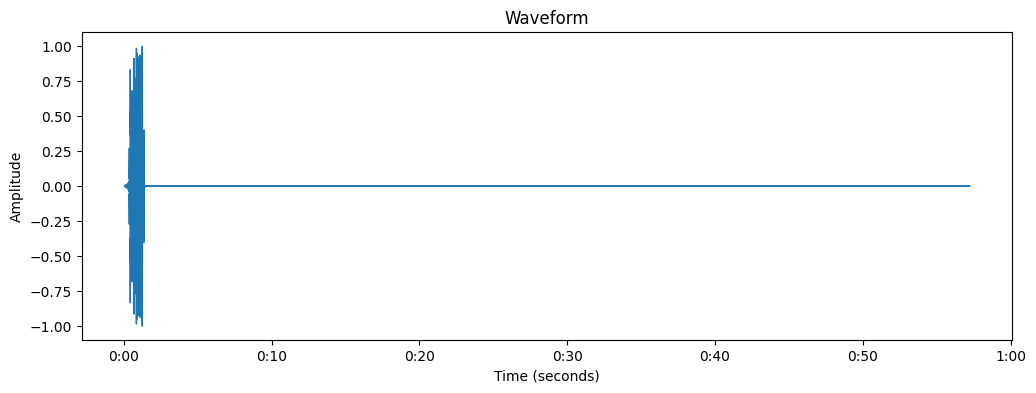

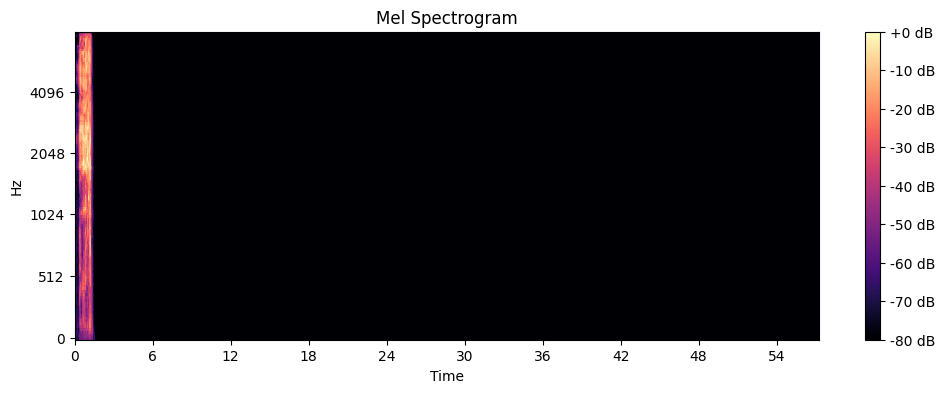

In [ ]:
from IPython.display import clear_output

dasd = asd[(asd["silence_ratio"] >= 0.975)]

df = dasd.sort_values("silence_ratio", ascending=False)

count = 0

for row in df.itertuples(index=True):
    
    if count > 0:
        count -= 1
        continue
    
    i = row.filename
    print(row.Index)
    print(i)
    
    audio_path = data_prefix + add_slash_if_needed(i)
    get_ann(stage1_json, i)
    
    print(f"silence_ratio : {row.silence_ratio:4f}, snr : {row.snr:4f}, flatness : {row.flatness:4f}, rms : {row.rms:4f}")
    
    print_wav_and_spectogram(audio_path)
    
    a = input()
    
    if "skip:" in a:
        count = int(a.split(":")[1])
        print(f"skipping {count} samples")
    elif a != "":
        break
        
    clear_output(wait=True)
    

Correlation Matrix:
               silence_ratio       snr  flatness       rms
silence_ratio       1.000000 -0.014042  0.591479 -0.208318
snr                -0.014042  1.000000 -0.029295  0.081698
flatness            0.591479 -0.029295  1.000000 -0.153177
rms                -0.208318  0.081698 -0.153177  1.000000


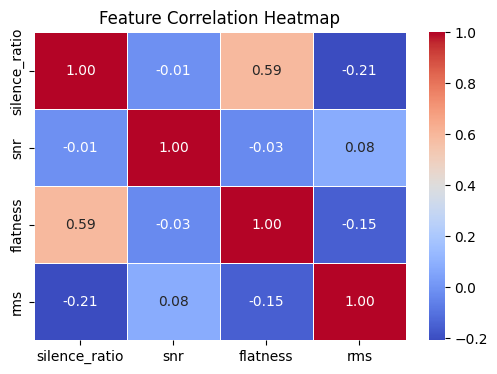

In [ ]:
features = ['silence_ratio', 'snr', 'flatness', 'rms']
ddasd = asd[features]

# 상관계수 계산
correlation_matrix = ddasd.corr()

# 결과 출력
print("Correlation Matrix:")
print(correlation_matrix)

# 상관행렬 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()

Correlation Matrix:
               silence_ratio       snr  flatness       rms
silence_ratio       1.000000 -0.030369  0.593124 -0.205164
snr                -0.030369  1.000000 -0.044344  0.092633
flatness            0.593124 -0.044344  1.000000 -0.139060
rms                -0.205164  0.092633 -0.139060  1.000000


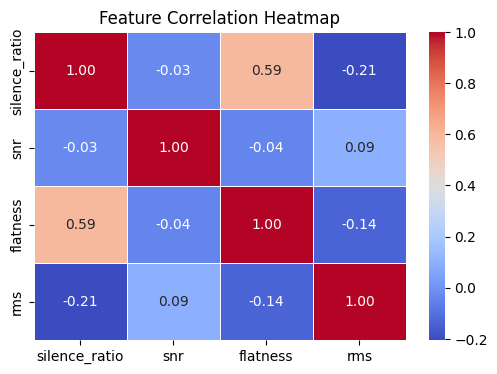

In [49]:
stage2_metadata = pd.read_csv("D:\\work_dir\\data\\stage2_train_audio_metadata_v2.csv")

features = ['silence_ratio', 'snr', 'flatness', 'rms']
ddasd = stage2_metadata[features]

# 상관계수 계산
correlation_matrix = ddasd.corr()

# 결과 출력
print("Correlation Matrix:")
print(correlation_matrix)

# 상관행렬 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()

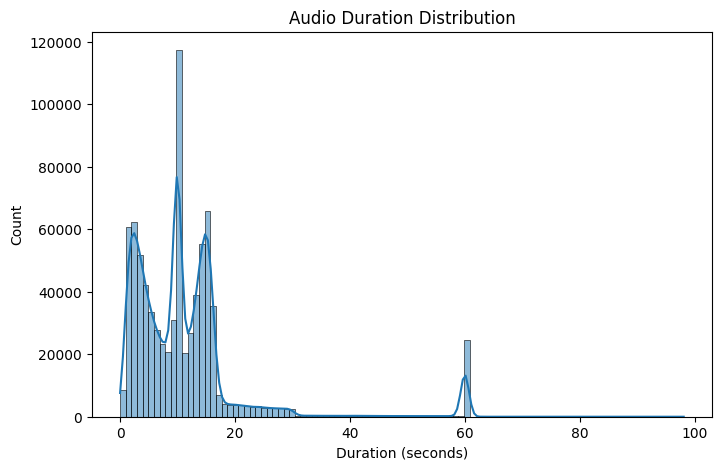

In [64]:

asdasdasd = stage2_metadata[stage2_metadata["duration_sec"] <= 100]

print_audio_duration_distribution(asdasdasd, bins=100)

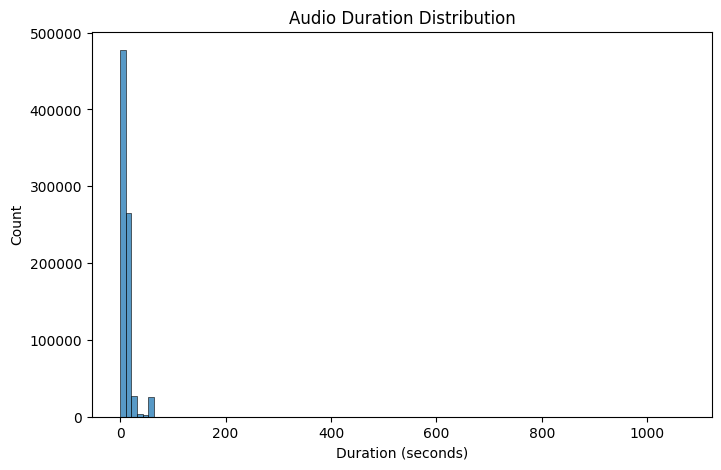

In [66]:
print_audio_duration_distribution(stage2_metadata, bins=100, kde=False)

In [67]:
stage2_metadata.sort_values("duration_sec", ascending=False)

filename             task  sample_rate  \
636927                /MusicNet/train/2315.wav               QA        16000   
551200                /MusicNet/train/2533.wav               QA        16000   
586044                /MusicNet/train/2443.wav               QA        16000   
600137                /MusicNet/train/2531.wav               QA        16000   
527921                /MusicNet/train/2366.wav               QA        16000   
...                                        ...              ...          ...   
120748  /WavCaps/AudioSet_SL/YTKNgW-VFIyw.flac               QA        16000   
12641   /WavCaps/AudioSet_SL/YeNb-ZoDx1r4.flac               QA        16000   
801500           /audiocaps_1m/train/72870.wav  audiocaption_v2        16000   
801501           /audiocaps_1m/train/24172.wav  audiocaption_v2        16000   
801502           /audiocaps_1m/train/20994.wav  audiocaption_v2        16000   

        channels  duration_sec          bit_depth  silence_ratio  \
636927         1   1069.035125  Signed 16 bit PCM       0.004586   
551200         1   1067.964125  Signed 16 bit PCM       0.008268   
586044         1   1035.128187  Signed 16 bit PCM       0.006663   
600137         1    992.104500  Signed 16 bit PCM       0.006067   
527921         1    941.165750  Signed 16 bit PCM       0.009410   
...          ...           ...                ...            ...   
120748         1      0.493500  Signed 16 bit PCM       0.091692   
12641          1      0.473500  Signed 16 bit PCM       0.461589   
801500         2      0.000000  Signed 32 bit PCM            NaN   
801501         2      0.000000  Signed 32 bit PCM            NaN   
801502         2      0.000000  Signed 32 bit PCM            NaN   

                 snr  flatness       rms  
636927 -7.765791e-07  0.002309  0.038196  
551200 -2.588597e-07  0.000306  0.027359  
586044  6.730347e-06  0.002080  0.034466  
600137  5.177193e-07  0.002238  0.038313  
527921 -1.035439e-06  0.004658  0.075825  
...              ...       ...       ...  
120748  5.177193e-07  0.311270  0.045245  
12641  -5.177194e-07  0.077086  0.076085  
801500           inf  1.000001  0.000000  
801501           inf  1.000001  0.000000  
801502           inf  1.000001  0.000000  

[801503 rows x 10 columns]

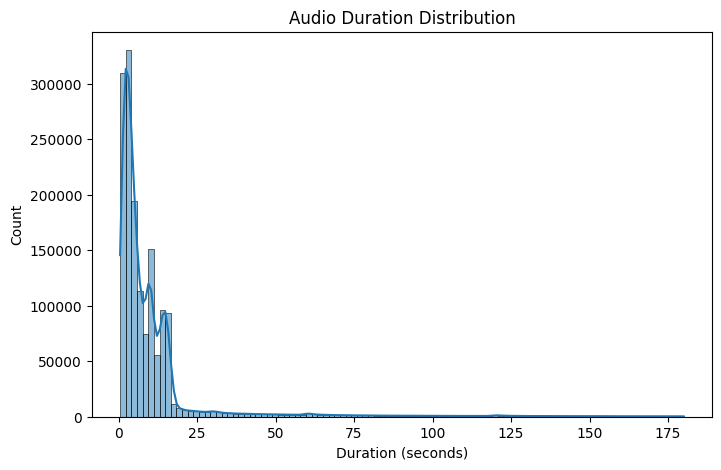

In [60]:
print_audio_duration_distribution(asd, bins=100)

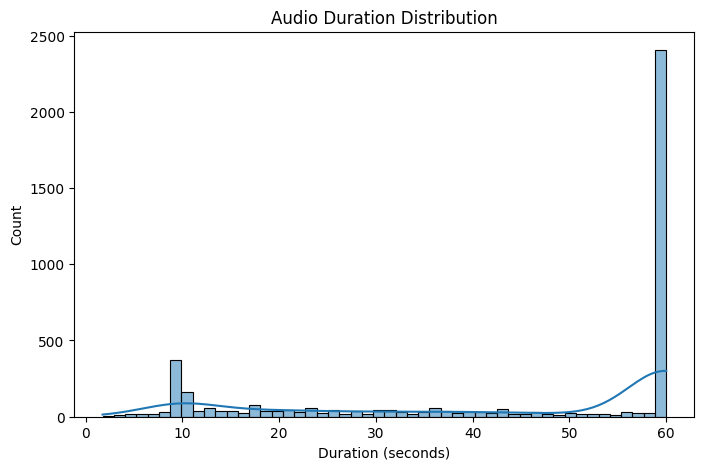

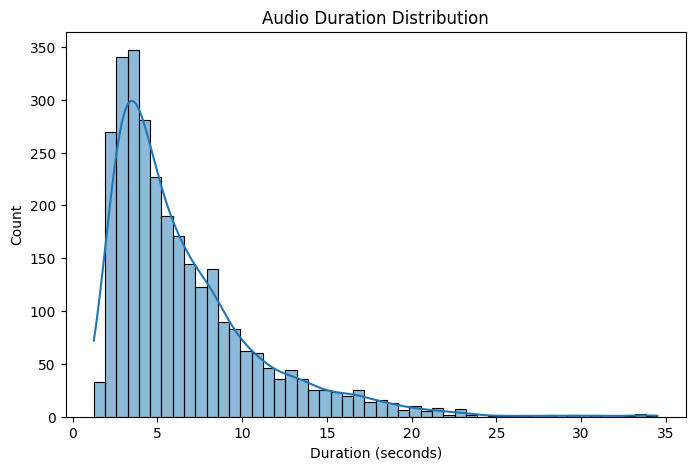

In [63]:
test_aac = pd.read_csv("D:\\work_dir\\data\\test_aac_audio_metadata_v2.csv")
test_asr = pd.read_csv("D:\\work_dir\\data\\test_asr_audio_metadata_v2.csv")

print_audio_duration_distribution(test_aac)
print_audio_duration_distribution(test_asr)